In [965]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py 
import plotly.graph_objs as go
import networkx as nx
from datetime import timedelta
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
print(' imported')


 imported


In [966]:
input_data_path = "C:/Users/xxx/OneDrive/Documents/Python Scripts/hypertension_data_book.xlsx"
df_diagnosis = pd.read_excel(input_data_path, sheet_name='diagnosis_table')
df_diagnosis.info()

# diagnosis_icd_category is added to the table as a higher level grouping for diagnosis ICD codes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64020 entries, 0 to 64019
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   patient_id_number          64020 non-null  int64         
 1   claim_id_number            64020 non-null  float64       
 2   diagnosis_date             64020 non-null  datetime64[ns]
 3   diagnosis_icd_code         64020 non-null  object        
 4   diagnosis_icd_description  64020 non-null  object        
 5   physician_id_number        44659 non-null  float64       
 6   physician_specialty        44639 non-null  object        
 7   diagnosis_icd_category     64020 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 3.9+ MB


In [967]:
df_prescription = pd.read_excel(input_data_path, sheet_name='prescription_table')
df_prescription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   claim_id_number           3066 non-null   float64       
 1   patient_id_number         3066 non-null   int64         
 2   physician_id_number       3066 non-null   int64         
 3   physician_specialty       3030 non-null   object        
 4   patient_paid_amount       2869 non-null   float64       
 5   prescription_quantity     3066 non-null   int64         
 6   prescription_days_supply  3066 non-null   int64         
 7   prescription_filled_date  3066 non-null   datetime64[ns]
 8   drug_brand_name           3066 non-null   object        
 9   drug_generic_name         3066 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 239.7+ KB


In [968]:
df_patient = pd.read_excel(input_data_path, sheet_name='patient_demographics_table')
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   patient_id_number  200 non-null    int64 
 1   patient_age        200 non-null    int64 
 2   patient_gender     200 non-null    object
dtypes: int64(2), object(1)
memory usage: 4.8+ KB


In [969]:
# examine data one by one

df = df_diagnosis
#df = df_prescription
#df = df_patient

# check duplicate rows
duplicates = df.duplicated()
duplicate_rows = df[duplicates]

print(f'dup', duplicate_rows)

# check missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})

print(missing_value_df)

# check zero values
percent_zero = (df==0).sum() * 100 / len(df)
zero_value_df = pd.DataFrame({'column_name': df.columns, 'percent_zero': percent_zero})

print(zero_value_df)

# check zero values
percent_zero = (df=='0').sum() * 100 / len(df)
zero_value_df = pd.DataFrame({'column_name': df.columns, 'percent_zero': percent_zero})

print(zero_value_df)

# check stats
df.describe()

# conclusion
# impactful data missing: 
# # diagnosis table missing 30% physician id and specialty - remove them from physician analysis, but keep them for diagnosis anlaysis, 
# # # if have time can impute based on patient and diagnosis date assuming a pateint often visits the same primary care doctor
# # prescription table missing 6% patient paid maount - impute them in following steps
# # prescription table have 2% prescription quantity and prescription days supply as zero - might be data entry issue or placeholder, no action as limited impact
# # prescription table missing 1% physician id - no impact

dup Empty DataFrame
Columns: [patient_id_number, claim_id_number, diagnosis_date, diagnosis_icd_code, diagnosis_icd_description, physician_id_number, physician_specialty, diagnosis_icd_category]
Index: []
                                         column_name  percent_missing
patient_id_number                  patient_id_number         0.000000
claim_id_number                      claim_id_number         0.000000
diagnosis_date                        diagnosis_date         0.000000
diagnosis_icd_code                diagnosis_icd_code         0.000000
diagnosis_icd_description  diagnosis_icd_description         0.000000
physician_id_number              physician_id_number        30.242112
physician_specialty              physician_specialty        30.273352
diagnosis_icd_category        diagnosis_icd_category         0.000000
                                         column_name  percent_zero
patient_id_number                  patient_id_number           0.0
claim_id_number                

,patient_id_number,claim_id_number,diagnosis_date,physician_id_number
count,6.402000e+04,6.402000e+04,64020,4.465900e+04
mean,1.606914e+09,1.841995e+17,2016-12-17 21:32:10.571696384,1.927159e+07
min,1.676880e+08,1.085330e+15,2014-03-02 00:00:00,3.359300e+04
25%,3.548165e+08,2.902847e+15,2015-12-13 00:00:00,1.591082e+06
50%,6.399033e+08,6.455824e+15,2017-01-15 00:00:00,1.997193e+07
75%,1.249577e+09,6.691066e+16,2018-02-13 00:00:00,3.599216e+07
max,5.288675e+10,2.165509e+21,2019-03-01 00:00:00,5.589828e+07
std,5.342007e+09,8.868018e+18,NaN,1.612441e+07


In [970]:
# as diagnosis and prescription have records up to 2019, thus we assume patient age is also as of 2019 when the the data book was extracted or cut off
# personal experience DOB is recorded in system and age is derived based on data extraction timestamp
# if we have more time, we can redo analysis assuming age was when the patient received first hypertension diagnosis 
# the data span is from 2014 to Jan 2019, about 5 years, we group patient age into 10 years buckets
df_patient.rename(columns={"patient_age": "patient_age_as_of_2019"}, inplace=True)
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   patient_id_number       200 non-null    int64 
 1   patient_age_as_of_2019  200 non-null    int64 
 2   patient_gender          200 non-null    object
dtypes: int64(2), object(1)
memory usage: 4.8+ KB


In [971]:
# add drug type (brand or generic) column to prescription

# function to normalize drug names by replacing '-' and '/' with a space
def normalize_name(name):
    if isinstance(name, str):
        return name.replace('-', ' ').replace('/', ' ').lower().strip()
    return name

# normalize both the drug_brand_name and drug_generic_name columns
df_prescription['normalized_brand_name'] = df_prescription['drug_brand_name'].apply(normalize_name)
df_prescription['normalized_generic_name'] = df_prescription['drug_generic_name'].apply(normalize_name)

# get the unique normalized generic names from the dataset
unique_normalized_generic_names = df_prescription['normalized_generic_name'].unique().tolist()

# create a new column to mark if the normalized drug_brand_name exists in any normalized drug_generic_name
df_prescription['drug_type'] = df_prescription['normalized_brand_name'].apply(
    lambda brand: 'Generic Drug' if brand in unique_normalized_generic_names else 'Brand Drug'
)

# drop the intermediate normalized columns if no longer needed
df_prescription.drop(columns = ['normalized_brand_name', 'normalized_generic_name'], inplace=True)

df_prescription.head()


,claim_id_number,patient_id_number,physician_id_number,physician_specialty,patient_paid_amount,prescription_quantity,prescription_days_supply,prescription_filled_date,drug_brand_name,drug_generic_name,drug_type
0,1.876393e+17,221286115,8360856,FAMILY MEDICINE,2.12,30,30,2018-07-27,LISINOPRIL,LISINOPRIL,Generic Drug
1,1.166025e+17,221286115,4317222,FAMILY MEDICINE,2.12,30,30,2018-06-29,LISINOPRIL,LISINOPRIL,Generic Drug
2,8.194494e+16,221286115,112636200,FAMILY MEDICINE,2.12,30,30,2018-08-25,LISINOPRIL,LISINOPRIL,Generic Drug
3,8.455070e+16,221286115,3924838,FAMILY MEDICINE,9.67,30,30,2014-12-12,VALSARTAN-HYDROCHLOROTHIAZIDE,VALSARTAN/HYDROCHLOROTHIAZIDE,Generic Drug
4,1.094049e+17,221286115,11828785,FAMILY MEDICINE,9.67,30,30,2014-10-15,VALSARTAN-HYDROCHLOROTHIAZIDE,VALSARTAN/HYDROCHLOROTHIAZIDE,Generic Drug


In [972]:
# add diagnosis helper fields: first/latest hypertension diagnosis date, hypertension diagnosis indicator

# aggregate data to find first and latest hypertension diagnosis dates
agg_dates = df_diagnosis[df_diagnosis['diagnosis_icd_description'].str.contains('hypertension', case = False)]
agg_dates = agg_dates.groupby('patient_id_number').agg(
    first_hypertension_diagnosis_date = ('diagnosis_date', 'min'),
    latest_hypertension_diagnosis_date = ('diagnosis_date', 'max')
).reset_index()

# create hypertension_diagnosis_ind column
df_diagnosis['hypertension_diagnosis_ind'] = np.where(
    df_diagnosis['diagnosis_icd_description'].str.contains('hypertension', case=False),
    'Hypertension',
    'Non-Hypertension'
)

df_diagnosis_master.head()

,patient_id_number,claim_id_number,diagnosis_date,diagnosis_icd_code,diagnosis_icd_description,physician_id_number,physician_specialty,diagnosis_icd_category,hypertension_diagnosis_ind,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date,eom_date
1,6635892201,2.265223e+15,2016-10-15,I10,ESSENTIAL (PRIMARY) HYPERTENSION,37668279.0,INTERNAL MEDICINE,I10,Hypertension,64,M,2016-10-15,2016-10-15,2016-10-31
32,6635892201,2.722990e+15,2016-10-15,I10,ESSENTIAL (PRIMARY) HYPERTENSION,37668279.0,INTERNAL MEDICINE,I10,Hypertension,64,M,2016-10-15,2016-10-15,2016-10-31
122,192233761,2.521714e+15,2014-09-22,401.9,UNSPECIFIED ESSENTIAL HYPERTENSION,35989691.0,GENERAL SURGERY,401,Hypertension,78,F,2014-09-22,2019-02-02,2014-09-30
156,192233761,1.135434e+16,2014-11-02,401.9,UNSPECIFIED ESSENTIAL HYPERTENSION,36149772.0,FAMILY MEDICINE,401,Hypertension,78,F,2014-09-22,2019-02-02,2014-11-30
196,192233761,4.359586e+15,2015-01-23,401.9,UNSPECIFIED ESSENTIAL HYPERTENSION,1626750.0,ANESTHESIOLOGY,401,Hypertension,78,F,2014-09-22,2019-02-02,2015-01-31


In [973]:
# merge diagnosis and patient
merged_diagnosis_patient = pd.merge(df_diagnosis, df_patient, on = 'patient_id_number', how = 'left')
df_diagnosis_master = pd.merge(merged_diagnosis_patient, agg_dates, on = 'patient_id_number', how = 'left')

df_diagnosis_master.head()

,patient_id_number,claim_id_number,diagnosis_date,diagnosis_icd_code,diagnosis_icd_description,physician_id_number,physician_specialty,diagnosis_icd_category,hypertension_diagnosis_ind,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date
0,6635892201,4.113227e+15,2014-03-26,493.9,"ASTHMA, UNSPECIFIED TYPE, UNSPECIFIED",NaN,NaN,493,Non-Hypertension,64,M,2016-10-15,2016-10-15
1,6635892201,2.265223e+15,2016-10-15,I10,ESSENTIAL (PRIMARY) HYPERTENSION,37668279.0,INTERNAL MEDICINE,I10,Hypertension,64,M,2016-10-15,2016-10-15
2,6635892201,2.460923e+15,2016-10-15,E03.9,"HYPOTHYROIDISM, UNSPECIFIED",37668279.0,INTERNAL MEDICINE,E03,Non-Hypertension,64,M,2016-10-15,2016-10-15
3,6635892201,3.468403e+15,2016-10-15,N30.00,ACUTE CYSTITIS WITHOUT HEMATURIA,37668279.0,INTERNAL MEDICINE,N30,Non-Hypertension,64,M,2016-10-15,2016-10-15
4,6635892201,5.246783e+15,2016-10-15,E78.5,"HYPERLIPIDEMIA, UNSPECIFIED",37668279.0,INTERNAL MEDICINE,E78,Non-Hypertension,64,M,2016-10-15,2016-10-15


In [974]:
# merge prescription and patient
merged_prescription_patient = pd.merge(df_prescription, df_patient, on = 'patient_id_number', how = 'left')
df_prescription_master = pd.merge(merged_prescription_patient, agg_dates, on = 'patient_id_number', how = 'left')

df_prescription_master.head()

,claim_id_number,patient_id_number,physician_id_number,physician_specialty,patient_paid_amount,prescription_quantity,prescription_days_supply,prescription_filled_date,drug_brand_name,drug_generic_name,drug_type,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date
0,1.876393e+17,221286115,8360856,FAMILY MEDICINE,2.12,30,30,2018-07-27,LISINOPRIL,LISINOPRIL,Generic Drug,66,F,2018-01-08,2019-01-29
1,1.166025e+17,221286115,4317222,FAMILY MEDICINE,2.12,30,30,2018-06-29,LISINOPRIL,LISINOPRIL,Generic Drug,66,F,2018-01-08,2019-01-29
2,8.194494e+16,221286115,112636200,FAMILY MEDICINE,2.12,30,30,2018-08-25,LISINOPRIL,LISINOPRIL,Generic Drug,66,F,2018-01-08,2019-01-29
3,8.455070e+16,221286115,3924838,FAMILY MEDICINE,9.67,30,30,2014-12-12,VALSARTAN-HYDROCHLOROTHIAZIDE,VALSARTAN/HYDROCHLOROTHIAZIDE,Generic Drug,66,F,2018-01-08,2019-01-29
4,1.094049e+17,221286115,11828785,FAMILY MEDICINE,9.67,30,30,2014-10-15,VALSARTAN-HYDROCHLOROTHIAZIDE,VALSARTAN/HYDROCHLOROTHIAZIDE,Generic Drug,66,F,2018-01-08,2019-01-29


In [975]:
# impute patient_paid_amount in prescription master: 
# If a prescription with blank paid amount has a fill date a lot earlier than expected fill date based on previous fill date and days supply, 
# we would assume the patient paid amount is missing due to missed data entry. We will fill it with the same amount as previous prescription, 
# based on the same drug and same supply. For other cases, we would assume the prescription is bad data or a placeholder for other unknown purpose, 
# and we would exclude them from analysis. 

# convert prescription filled date to datetime
df_prescription_master['prescription_filled_date'] = pd.to_datetime(df_prescription_master['prescription_filled_date'])

# fill missing values in prescription days_supply and convert to integer 
df_prescription_master['prescription_days_supply'] = df_prescription_master['prescription_days_supply'].fillna(0).astype(int)

# sort DataFrame by patient_id_number, drug_brand_name, and prescription_ filled_date
df_prescription_master.sort_values(by = ['patient_id_number', 'drug_brand_name', 'prescription_filled_date'], inplace = True)

# imputation logic
def impute_patient_paid_amount(group):
    group = group.reset_index(drop = True)
    for i in range(1, len(group)):
        if pd.isna(group.loc[i, 'patient_paid_amount']):
            prev_date = group.loc[i - 1, 'prescription_filled_date']
            prev_days_supply = int(group.loc[i - 1, 'prescription_days_supply'])
            prev_quantity = group.loc[i - 1, 'prescription_quantity'] 
            expected_next_date = prev_date + timedelta(days = prev_days_supply)

            # Add a one-week buffer before and after the expected next date
            buffer = timedelta(days = 7)
            current_date = group.loc[i, 'prescription_filled_date'] 
            current_quantity = group.loc[i, 'prescription_quantity'] 
            current_days_supply = group.loc[i, 'prescription_days_supply']

            # check if the current fill date is within the expected range with buffer and has the same quantity and supply days as previous fill
            if (expected_next_date - buffer <= current_date <= expected_next_date + buffer) and \
                (current_quantity == prev_quantity) and \
                (current_days_supply == prev_days_supply):
                group.loc[i, 'patient_paid_amount'] = group.loc[i - 1, 'patient_paid_amount']
                #group.loc[i, 'imputed'] = True # mark the row as imputed
            else:
                # mark as bad entry
                group.loc[i, 'bad_entry'] = True

    return group

# apply the imputation function group-wise
df_prescription_master = df_prescription_master.groupby(['patient_id_number', 'drug_brand_name']).apply(impute_patient_paid_amount)

# remove bad entries
df_prescription_master = df_prescription_master[df_prescription_master.get('bad_entry') != True]

# drop the helper column
df_prescription_master.drop(columns=['bad_entry'], inplace = True, errors='ignore')

# flat the table
df_prescription_master = df_prescription_master.reset_index(drop = True)

df_prescription_master.head()


C:\Users\fzeng\AppData\Local\Temp\ipykernel_11628\574788555.py:45: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,claim_id_number,patient_id_number,physician_id_number,physician_specialty,patient_paid_amount,prescription_quantity,prescription_days_supply,prescription_filled_date,drug_brand_name,drug_generic_name,drug_type,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date
0,3.226178e+16,167687962,40304883,"FAMILY PRACTICE, GERIATRIC MEDICINE",2.36,90,0,2016-07-27,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17
1,1.360730e+17,167687962,3048888733,"FAMILY PRACTICE, GERIATRIC MEDICINE",2.36,90,90,2016-08-03,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17
2,2.513888e+17,167687962,131024851,"FAMILY PRACTICE, GERIATRIC MEDICINE",3.00,90,90,2016-10-20,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17
3,2.702500e+16,167687962,41953273,"FAMILY PRACTICE, GERIATRIC MEDICINE",2.36,90,0,2016-10-28,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17
4,8.016564e+17,167687962,58111030,"FAMILY PRACTICE, GERIATRIC MEDICINE",0.00,90,90,2017-01-11,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17


In [976]:
# add expected fill date to presecription master based on a ptient's same drug previous fill date and supply

# sort by patient_id_number, drug_brand_name, and prescription_filled_date
df_prescription_master.sort_values(by=['patient_id_number', 'drug_brand_name', 'prescription_filled_date'], inplace=True)

# function to calculate expected_fill_date
def calculate_expected_fill_date(group):
    group = group.reset_index(drop=True)  # Reset index for easier iteration
    for i in range(1, len(group)):
        # Get previous row details
        prev_date = group.loc[i - 1, 'prescription_filled_date']
        prev_days_supply = int(group.loc[i - 1, 'prescription_days_supply'])
        
        # Only calculate if previous days supply is greater than 0
        if prev_days_supply > 0:
            # Calculate the expected next fill date
            expected_next_date = prev_date + timedelta(days=prev_days_supply)
            
            # Assign the expected fill date to the current row
            group.loc[i, 'expected_fill_date'] = expected_next_date
        else:
            # Leave the expected fill date as NaT for cases where previous days supply is 0
            group.loc[i, 'expected_fill_date'] = pd.NaT
    
    return group

# apply the calculation patient and drug group
df_prescription_master['expected_fill_date'] = pd.NaT  # Initialize expected_fill_date column
df_prescription_master = df_prescription_master.groupby(['patient_id_number', 'drug_brand_name']).apply(calculate_expected_fill_date)

# flat the tabl
df_prescription_master = df_prescription_master.reset_index(drop = True)

df_prescription_master.head()

C:\Users\fzeng\AppData\Local\Temp\ipykernel_11628\373410021.py:29: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,claim_id_number,patient_id_number,physician_id_number,physician_specialty,patient_paid_amount,prescription_quantity,prescription_days_supply,prescription_filled_date,drug_brand_name,drug_generic_name,drug_type,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date,expected_fill_date
0,3.226178e+16,167687962,40304883,"FAMILY PRACTICE, GERIATRIC MEDICINE",2.36,90,0,2016-07-27,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17,NaT
1,1.360730e+17,167687962,3048888733,"FAMILY PRACTICE, GERIATRIC MEDICINE",2.36,90,90,2016-08-03,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17,NaT
2,2.513888e+17,167687962,131024851,"FAMILY PRACTICE, GERIATRIC MEDICINE",3.00,90,90,2016-10-20,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17,2016-11-01
3,2.702500e+16,167687962,41953273,"FAMILY PRACTICE, GERIATRIC MEDICINE",2.36,90,0,2016-10-28,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17,2017-01-18
4,8.016564e+17,167687962,58111030,"FAMILY PRACTICE, GERIATRIC MEDICINE",0.00,90,90,2017-01-11,LISINOPRIL,LISINOPRIL,Generic Drug,83,M,2014-03-09,2019-02-17,NaT


In [977]:
# check null values
df_diagnosis_master.isnull().sum()

patient_id_number                         0
claim_id_number                           0
diagnosis_date                            0
diagnosis_icd_code                        0
diagnosis_icd_description                 0
physician_id_number                   19361
physician_specialty                   19381
diagnosis_icd_category                    0
hypertension_diagnosis_ind                0
patient_age_as_of_2019                    0
patient_gender                            0
first_hypertension_diagnosis_date         0
latest_hypertension_diagnosis_date        0
dtype: int64

In [978]:
# check null values
df_prescription_master.isnull().sum()

claim_id_number                         0
patient_id_number                       0
physician_id_number                     0
physician_specialty                    33
patient_paid_amount                    22
prescription_quantity                   0
prescription_days_supply                0
prescription_filled_date                0
drug_brand_name                         0
drug_generic_name                       0
drug_type                               0
patient_age_as_of_2019                  0
patient_gender                          0
first_hypertension_diagnosis_date       0
latest_hypertension_diagnosis_date      0
expected_fill_date                    292
dtype: int64

In [979]:
# fill null with zero for the remaining unknown patient paid amount
df_prescription_master['patient_paid_amount'].fillna(value = 0, inplace = True)

C:\Users\fzeng\AppData\Local\Temp\ipykernel_11628\2122012781.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [980]:


## Patient Segmentation Analysis using K-Means Clustering



In [981]:
# create patient level analytical table for BI and modeling

# group by and aggregate the diagnostic data
df_diagnosis_grouped = df_diagnosis_master.groupby('patient_id_number').agg(
    patient_age_as_of_2019 = ('patient_age_as_of_2019','min'),
    patient_gender = ('patient_gender','min'),
    first_hypertension_diagnosis_date = ('first_hypertension_diagnosis_date','min'),
    latest_hypertension_diagnosis_date = ('latest_hypertension_diagnosis_date', 'min'), 
    number_of_diagnosis_claims = ('claim_id_number','nunique'),
    number_of_hypertension_diagnosis_claims = ('claim_id_number', lambda x: x[df_diagnosis_master['hypertension_diagnosis_ind'] == 'Hypertension'].nunique()), 
    number_of_diagnosis_icd_code = ('diagnosis_icd_code', 'nunique'), 
    number_of_diagnosis_icd_category = ('diagnosis_icd_category', 'nunique'),
    number_of_hypertension_diagnosis_icd_code = ('diagnosis_icd_code', lambda x: x[df_diagnosis_master['hypertension_diagnosis_ind'] == 'Hypertension'].nunique()),
    number_of_hypertension_diagnosis_icd_category = ('diagnosis_icd_category', lambda x: x[df_diagnosis_master['hypertension_diagnosis_ind'] == 'Hypertension'].nunique()), 
    number_of_non_hypertension_diagnosis_icd_code = ('diagnosis_icd_code', lambda x: x[df_diagnosis_master['hypertension_diagnosis_ind'] == 'Non-Hypertension'].nunique()), 
    number_of_non_hypertension_diagnosis_icd_category = ('diagnosis_icd_category', lambda x: x[df_diagnosis_master['hypertension_diagnosis_ind'] == 'Non-Hypertension'].nunique())
).reset_index()
df_diagnosis_grouped.head()


,patient_id_number,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date,number_of_diagnosis_claims,number_of_hypertension_diagnosis_claims,number_of_diagnosis_icd_code,number_of_diagnosis_icd_category,number_of_hypertension_diagnosis_icd_code,number_of_hypertension_diagnosis_icd_category,number_of_non_hypertension_diagnosis_icd_code,number_of_non_hypertension_diagnosis_icd_category
0,167687962,83,M,2014-03-09,2019-02-17,193,36,53,39,2,2,51,37
1,171406052,70,M,2015-09-26,2018-04-17,33,7,16,15,2,2,14,13
2,179330740,68,M,2014-05-25,2019-03-01,202,39,54,46,2,2,52,44
3,183741751,59,F,2014-04-05,2018-12-30,145,16,57,45,2,2,55,43
4,192233761,78,F,2014-09-22,2019-02-02,787,29,195,129,3,3,192,126


In [982]:
# group by and aggregate the prescription data
df_prescription_grouped = df_prescription_master.groupby('patient_id_number').agg(
    first_hypertension_prescription_flll_date = ('prescription_filled_date','min'),
    latest_hypertension_prescription_fill_date = ('prescription_filled_date','max'),
    hypertension_prescription_last_to_date = ('prescription_filled_date', lambda x:(pd.to_datetime(x) + pd.to_timedelta(df_prescription_master['prescription_days_supply'], unit='d')).max()),
    months_of_hypertension_treatment = ('prescription_filled_date', lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).days // 30), 
    days_of_hypertension_treatment = ('prescription_days_supply', 'sum'),
    number_of_hypertension_brand_drug_prescribed = ('drug_brand_name','nunique'),
    number_of_hypertension_prescription_claims = ('claim_id_number','nunique'),
    total_patient_paid_amount = ('patient_paid_amount', 'sum'), 
    avg_hypertension_prescription_patient_paid_amount = ('patient_paid_amount','mean'),    
    avg_daily_hypertension_prescription_patient_paid_amount = ('patient_paid_amount', lambda x: x.sum() / df_prescription_master['prescription_days_supply'].sum())
).reset_index()

# rename pateint id from presecription
df_prescription_grouped['patient_id_number_in_prescription'] = df_prescription_grouped['patient_id_number']

df_prescription_grouped.head()


,patient_id_number,first_hypertension_prescription_flll_date,latest_hypertension_prescription_fill_date,hypertension_prescription_last_to_date,months_of_hypertension_treatment,days_of_hypertension_treatment,number_of_hypertension_brand_drug_prescribed,number_of_hypertension_prescription_claims,total_patient_paid_amount,avg_hypertension_prescription_patient_paid_amount,avg_daily_hypertension_prescription_patient_paid_amount,patient_id_number_in_prescription
0,167687962,2014-01-02,2018-10-13,2019-01-11,58,1710,2,21,91.86,4.374286,0.000654,167687962
1,171406052,2014-03-06,2018-06-05,2018-07-05,51,390,3,16,552.07,34.504375,0.003932,171406052
2,179330740,2014-01-09,2018-11-28,2019-02-26,59,930,3,17,37.55,2.208824,0.000267,179330740
3,192233761,2018-01-22,2018-01-22,2018-02-06,0,15,1,1,0.00,0.000000,0.000000,192233761
4,197817490,2014-01-23,2018-12-27,2019-01-26,59,2160,2,72,120.00,1.666667,0.000855,197817490


In [983]:
# merge the diagnostic and prescription groupby data 
df_patient_summary = df_diagnosis_grouped.merge(df_prescription_grouped, left_on = 'patient_id_number', right_on = 'patient_id_number', how = 'left')

# add the hypertension_treatment_ind column
df_patient_summary['hypertension_treatment_ind'] = np.where(df_patient_summary['patient_id_number_in_prescription'].notnull(), 'Treatment', 'No Treatment')

# add days of diagnosis
df_patient_summary['first_hypertension_diagnosis_date'] = pd.to_datetime(df_patient_summary['first_hypertension_diagnosis_date'])
df_patient_summary['latest_hypertension_diagnosis_date'] = pd.to_datetime(df_patient_summary['latest_hypertension_diagnosis_date'])
df_patient_summary['days_of_hypertension_diagnosis'] = (
    df_patient_summary['latest_hypertension_diagnosis_date'] - df_patient_summary['first_hypertension_diagnosis_date']
).dt.days

df_patient_summary.head()

,patient_id_number,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date,number_of_diagnosis_claims,number_of_hypertension_diagnosis_claims,number_of_diagnosis_icd_code,number_of_diagnosis_icd_category,number_of_hypertension_diagnosis_icd_code,...,months_of_hypertension_treatment,days_of_hypertension_treatment,number_of_hypertension_brand_drug_prescribed,number_of_hypertension_prescription_claims,total_patient_paid_amount,avg_hypertension_prescription_patient_paid_amount,avg_daily_hypertension_prescription_patient_paid_amount,patient_id_number_in_prescription,hypertension_treatment_ind,days_of_hypertension_diagnosis
0,167687962,83,M,2014-03-09,2019-02-17,193,36,53,39,2,...,58.0,1710.0,2.0,21.0,91.86,4.374286,0.000654,167687962.0,Treatment,1806
1,171406052,70,M,2015-09-26,2018-04-17,33,7,16,15,2,...,51.0,390.0,3.0,16.0,552.07,34.504375,0.003932,171406052.0,Treatment,934
2,179330740,68,M,2014-05-25,2019-03-01,202,39,54,46,2,...,59.0,930.0,3.0,17.0,37.55,2.208824,0.000267,179330740.0,Treatment,1741
3,183741751,59,F,2014-04-05,2018-12-30,145,16,57,45,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Treatment,1730
4,192233761,78,F,2014-09-22,2019-02-02,787,29,195,129,3,...,0.0,15.0,1.0,1.0,0.00,0.000000,0.000000,192233761.0,Treatment,1594


In [984]:
# prep patient summary table for patient segmentation using k-means clustering
df_patient_summary['patient_age_as_of_2019'] = df_patient_summary['patient_age_as_of_2019'].astype(int)
df_patient_summary['days_of_hypertension_treatment'] = df_patient_summary['days_of_hypertension_treatment'].fillna(0)
df_patient_summary['number_of_hypertension_brand_drug_prescribed'] = df_patient_summary['number_of_hypertension_brand_drug_prescribed'].fillna(0)
df_patient_summary.isnull().sum()
df_patient_summary.describe()


,patient_id_number,patient_age_as_of_2019,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date,number_of_diagnosis_claims,number_of_hypertension_diagnosis_claims,number_of_diagnosis_icd_code,number_of_diagnosis_icd_category,number_of_hypertension_diagnosis_icd_code,number_of_hypertension_diagnosis_icd_category,...,hypertension_prescription_last_to_date,months_of_hypertension_treatment,days_of_hypertension_treatment,number_of_hypertension_brand_drug_prescribed,number_of_hypertension_prescription_claims,total_patient_paid_amount,avg_hypertension_prescription_patient_paid_amount,avg_daily_hypertension_prescription_patient_paid_amount,patient_id_number_in_prescription,days_of_hypertension_diagnosis
count,2.000000e+02,200.000000,200,200,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,139,139.000000,200.000000,200.000000,139.000000,139.000000,139.000000,139.000000,1.390000e+02,200.000000
mean,2.023492e+09,69.240000,2015-05-03 02:31:12,2018-06-17 06:43:12,320.100000,37.480000,71.945000,53.825000,2.190000,1.895000,...,2018-02-14 06:23:18.561150976,37.230216,702.010000,1.165000,20.935252,195.897626,8.218121,0.001395,1.197321e+09,1141.175000
min,1.676880e+08,23.000000,2014-03-02 00:00:00,2016-02-17 00:00:00,6.000000,1.000000,2.000000,2.000000,1.000000,1.000000,...,2014-03-24 00:00:00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.676880e+08,0.000000
25%,3.514149e+08,59.750000,2014-04-18 00:00:00,2018-02-14 12:00:00,81.000000,7.000000,32.000000,27.000000,1.000000,1.000000,...,2017-07-14 12:00:00,21.500000,0.000000,0.000000,9.000000,18.710000,1.348846,0.000133,3.128311e+08,703.000000
50%,6.465799e+08,73.000000,2014-09-15 00:00:00,2018-10-13 00:00:00,189.500000,18.000000,59.500000,46.500000,2.000000,2.000000,...,2018-11-26 00:00:00,42.000000,555.000000,1.000000,19.000000,75.090000,4.550000,0.000535,5.701289e+08,1327.500000
75%,1.433706e+09,83.000000,2016-03-13 12:00:00,2019-01-12 00:00:00,415.000000,30.250000,101.500000,76.000000,3.000000,2.000000,...,2019-02-01 12:00:00,57.000000,1350.000000,2.000000,28.000000,176.845000,11.469667,0.001260,1.234430e+09,1649.250000
max,5.288675e+10,83.000000,2018-10-27 00:00:00,2019-03-01 00:00:00,3551.000000,1198.000000,245.000000,152.000000,7.000000,4.000000,...,2019-03-31 00:00:00,61.000000,2441.000000,5.000000,72.000000,5394.650000,107.893000,0.038423,1.362596e+10,1824.000000
std,5.909161e+09,13.276056,NaN,NaN,420.541157,111.666047,50.968134,33.597894,1.043718,0.704597,...,NaN,20.806324,709.957533,1.074031,15.427816,499.297764,12.318843,0.003556,1.840333e+09,583.005904


C:\Users\fzeng\AppData\Local\Temp\ipykernel_11628\1594614001.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\fzeng\AppData\Local\Temp\ipykernel_11628\1594614001.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\fzeng\AppData\Local\Temp\ipykernel_11628\1594614001.py:13: UserWarning:



`distplot`

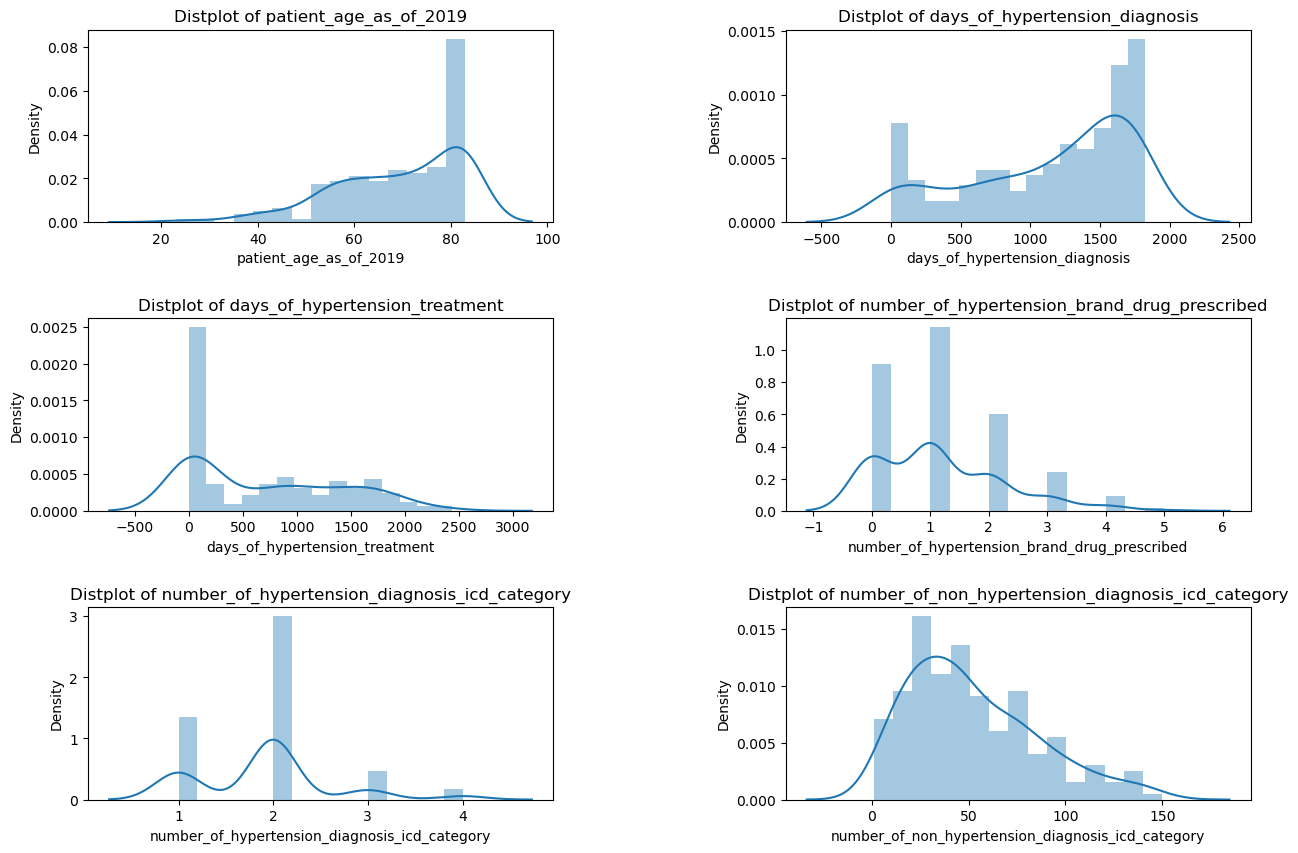

In [985]:
# pick 5 important features for patient clustering, check data distribution
plt.figure(1 , figsize = (15, 10))
n = 0
for x in ['patient_age_as_of_2019', 
          'days_of_hypertension_diagnosis', 
          'days_of_hypertension_treatment',
          'number_of_hypertension_brand_drug_prescribed',
          'number_of_hypertension_diagnosis_icd_category',
          'number_of_non_hypertension_diagnosis_icd_category']:
    n += 1
    plt.subplot(3, 2, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(df_patient_summary[x], bins = 15)
    plt.title('Distplot of {}'.format(x))

plt.show()


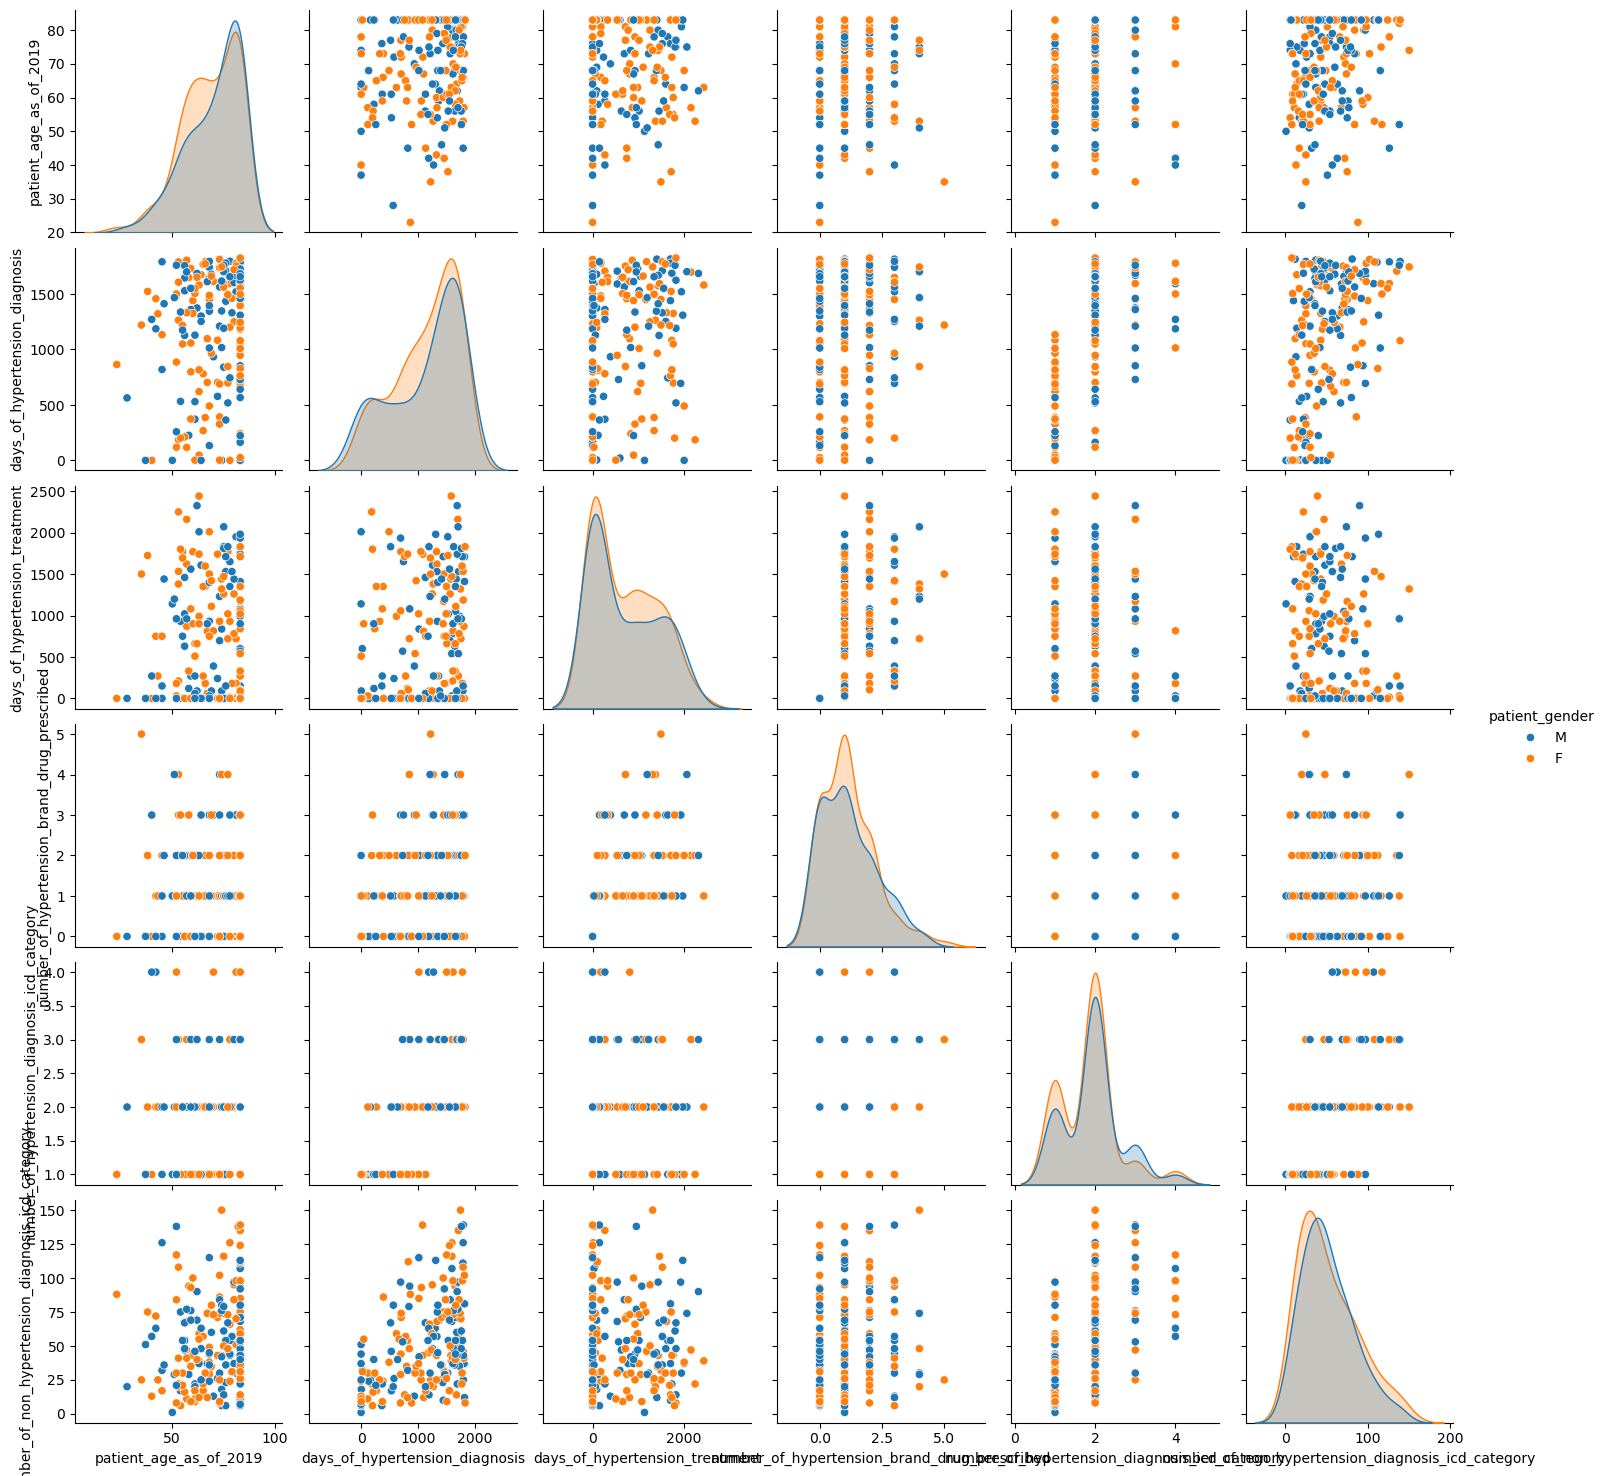

In [986]:
# check correlation
sns.pairplot(df_patient_summary, vars = [
    'patient_age_as_of_2019',
    'days_of_hypertension_diagnosis',
    'days_of_hypertension_treatment',
    'number_of_hypertension_brand_drug_prescribed',
    'number_of_hypertension_diagnosis_icd_category',
    'number_of_non_hypertension_diagnosis_icd_category'
], hue = 'patient_gender')


In [987]:
# scale before clustering

scaler = StandardScaler()

df_patient_summary[['patient_age_as_of_2019_t',
                    'days_of_hypertension_diagnosis_t',
                    'days_of_hypertension_treatment_t',
                    'number_of_hypertension_brand_drug_prescribed_t',
                    'number_of_hypertension_diagnosis_icd_category_t',
                    'number_of_non_hypertension_diagnosis_icd_category_t']] = scaler.fit_transform(
                        df_patient_summary[['patient_age_as_of_2019',
                        'days_of_hypertension_diagnosis',
                        'days_of_hypertension_treatment',
                        'number_of_hypertension_brand_drug_prescribed',
                        'number_of_hypertension_diagnosis_icd_category',
                        'number_of_non_hypertension_diagnosis_icd_category']]
                    )
df_patient_summary.head()

,patient_id_number,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date,number_of_diagnosis_claims,number_of_hypertension_diagnosis_claims,number_of_diagnosis_icd_code,number_of_diagnosis_icd_category,number_of_hypertension_diagnosis_icd_code,...,avg_daily_hypertension_prescription_patient_paid_amount,patient_id_number_in_prescription,hypertension_treatment_ind,days_of_hypertension_diagnosis,patient_age_as_of_2019_t,days_of_hypertension_diagnosis_t,days_of_hypertension_treatment_t,number_of_hypertension_brand_drug_prescribed_t,number_of_hypertension_diagnosis_icd_category_t,number_of_non_hypertension_diagnosis_icd_category_t
0,167687962,83,M,2014-03-09,2019-02-17,193,36,53,39,2,...,0.000654,167687962.0,Treatment,1806,1.039053,1.143202,1.423352,0.779396,0.149395,-0.450353
1,171406052,70,M,2015-09-26,2018-04-17,33,7,16,15,2,...,0.003932,171406052.0,Treatment,934,0.057390,-0.356248,-0.440580,1.712804,0.149395,-1.172361
2,179330740,68,M,2014-05-25,2019-03-01,202,39,54,46,2,...,0.000267,179330740.0,Treatment,1741,-0.093636,1.031431,0.321938,1.712804,0.149395,-0.239767
3,183741751,59,F,2014-04-05,2018-12-30,145,16,57,45,2,...,NaN,NaN,No Treatment,1730,-0.773249,1.012516,-0.991287,-1.087421,0.149395,-0.269851
4,192233761,78,F,2014-09-22,2019-02-02,787,29,195,129,3,...,0.000000,192233761.0,Treatment,1594,0.661490,0.778656,-0.970106,-0.154012,1.572207,2.227094


C:\Users\fzeng\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\fzeng\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\fzeng\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\fzeng\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

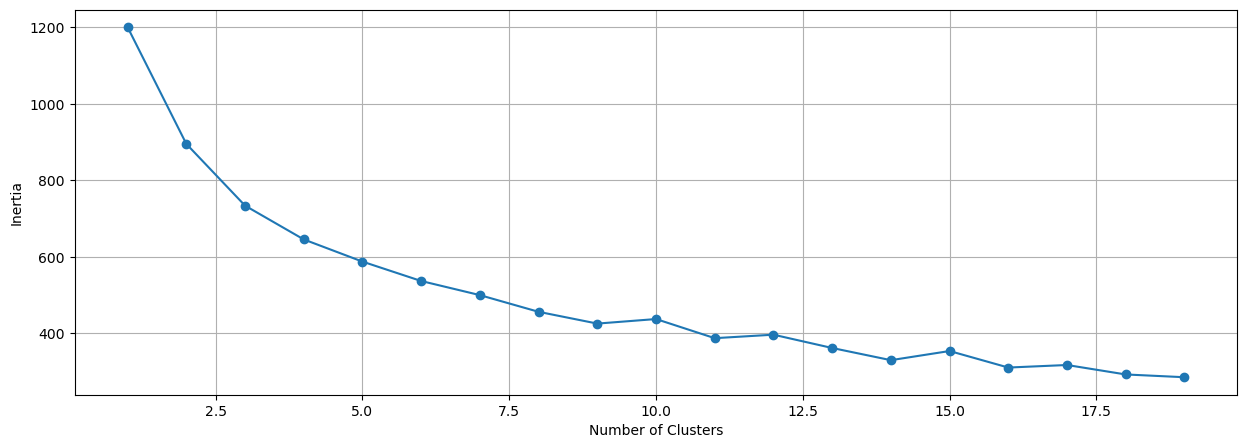

In [988]:
# use elbow plot to find k

def optimise_k_means(data, max_k):
    means = []
    inertias = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    #generate the elbow plot
    fig = plt.subplots(figsize = (15, 5))
    plt.plot(means, inertias, 'o-') 
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

optimise_k_means(df_patient_summary[['patient_age_as_of_2019_t',
                    'days_of_hypertension_diagnosis_t',
                    'days_of_hypertension_treatment_t',
                    'number_of_hypertension_brand_drug_prescribed_t',
                    'number_of_hypertension_diagnosis_icd_category_t',
                    'number_of_non_hypertension_diagnosis_icd_category_t']],20)



In [989]:
# 4 seems a good k
kmeans = KMeans(n_clusters = 4)
kmeans.fit(df_patient_summary[['patient_age_as_of_2019_t',
                    'days_of_hypertension_diagnosis_t',
                    'days_of_hypertension_treatment_t',
                    'number_of_hypertension_brand_drug_prescribed_t',
                    'number_of_hypertension_diagnosis_icd_category_t',
                    'number_of_non_hypertension_diagnosis_icd_category_t']])

df_patient_summary['kmeans_label'] = kmeans.labels_
df_patient_summary. head()


C:\Users\fzeng\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



,patient_id_number,patient_age_as_of_2019,patient_gender,first_hypertension_diagnosis_date,latest_hypertension_diagnosis_date,number_of_diagnosis_claims,number_of_hypertension_diagnosis_claims,number_of_diagnosis_icd_code,number_of_diagnosis_icd_category,number_of_hypertension_diagnosis_icd_code,...,patient_id_number_in_prescription,hypertension_treatment_ind,days_of_hypertension_diagnosis,patient_age_as_of_2019_t,days_of_hypertension_diagnosis_t,days_of_hypertension_treatment_t,number_of_hypertension_brand_drug_prescribed_t,number_of_hypertension_diagnosis_icd_category_t,number_of_non_hypertension_diagnosis_icd_category_t,kmeans_label
0,167687962,83,M,2014-03-09,2019-02-17,193,36,53,39,2,...,167687962.0,Treatment,1806,1.039053,1.143202,1.423352,0.779396,0.149395,-0.450353,1
1,171406052,70,M,2015-09-26,2018-04-17,33,7,16,15,2,...,171406052.0,Treatment,934,0.057390,-0.356248,-0.440580,1.712804,0.149395,-1.172361,3
2,179330740,68,M,2014-05-25,2019-03-01,202,39,54,46,2,...,179330740.0,Treatment,1741,-0.093636,1.031431,0.321938,1.712804,0.149395,-0.239767,3
3,183741751,59,F,2014-04-05,2018-12-30,145,16,57,45,2,...,NaN,No Treatment,1730,-0.773249,1.012516,-0.991287,-1.087421,0.149395,-0.269851,2
4,192233761,78,F,2014-09-22,2019-02-02,787,29,195,129,3,...,192233761.0,Treatment,1594,0.661490,0.778656,-0.970106,-0.154012,1.572207,2.227094,2


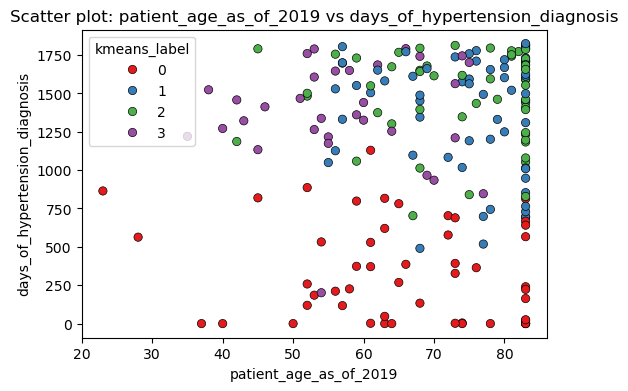

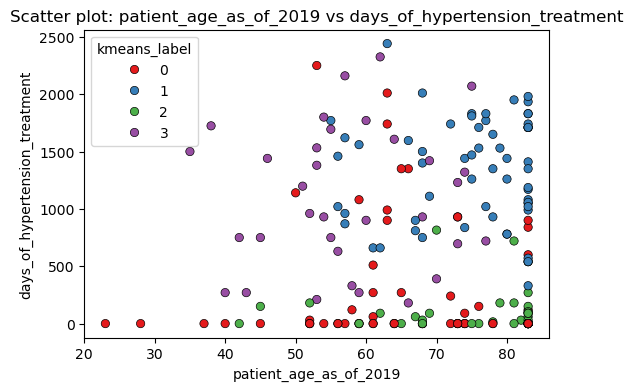

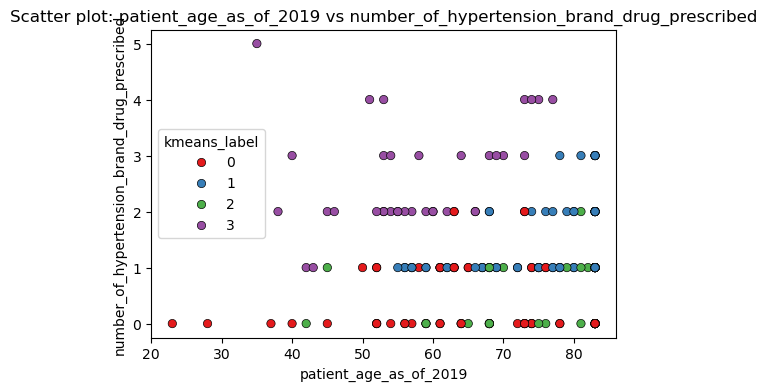

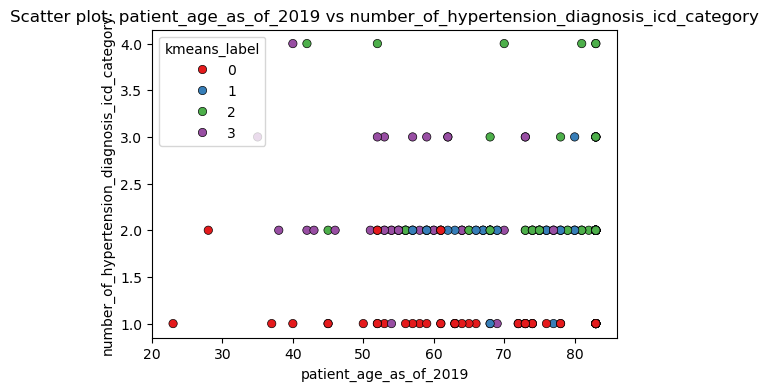

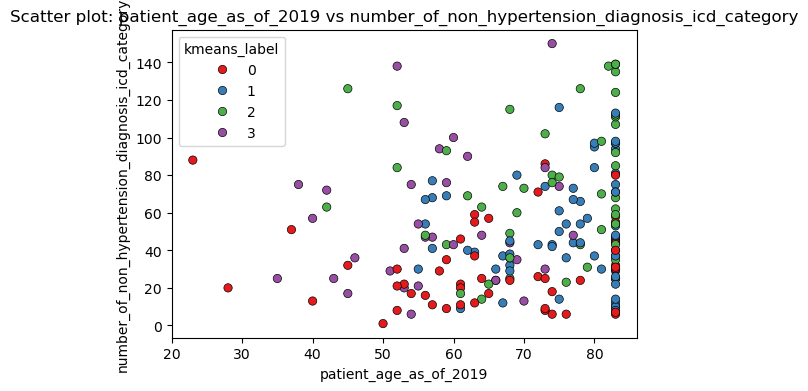

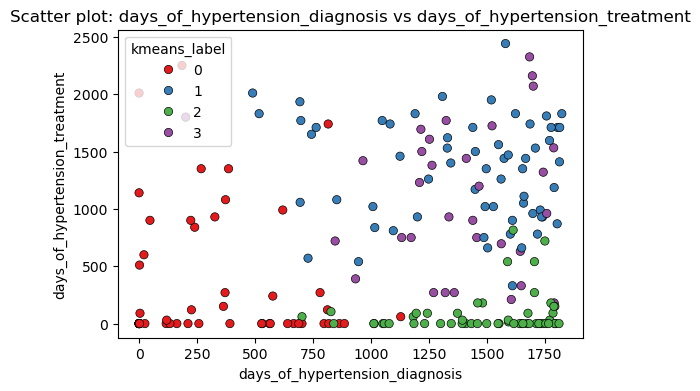

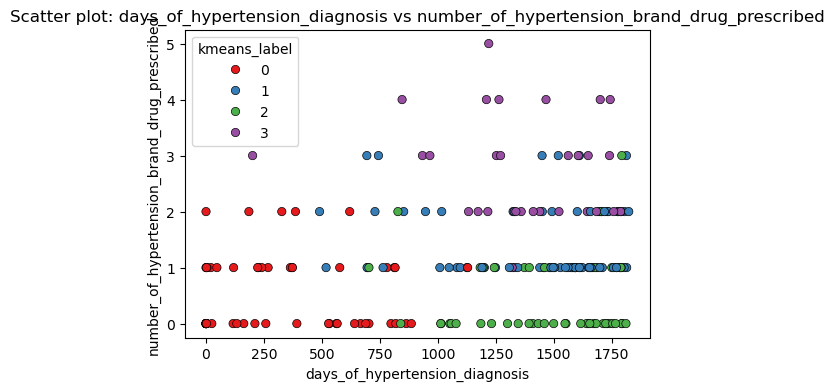

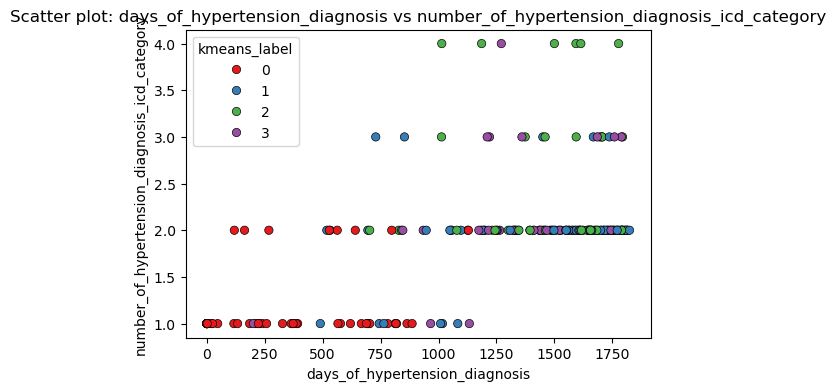

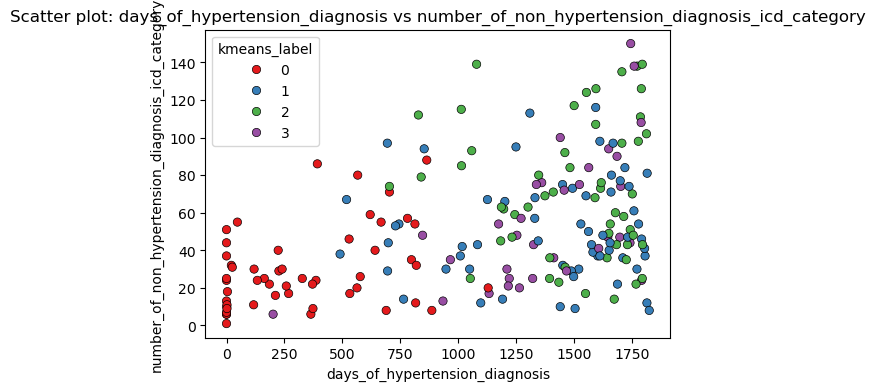

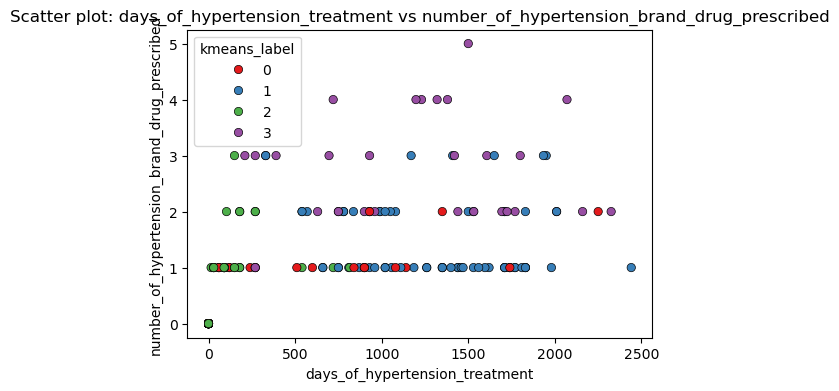

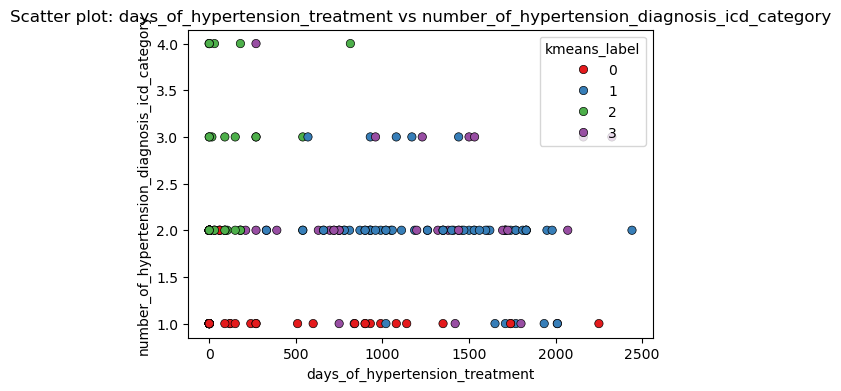

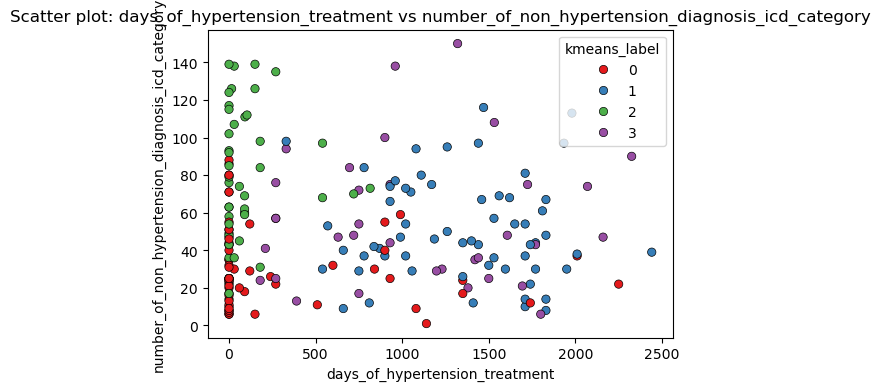

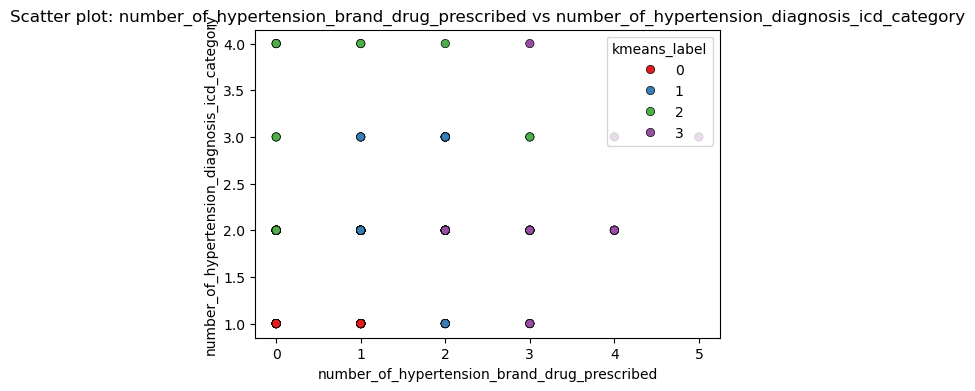

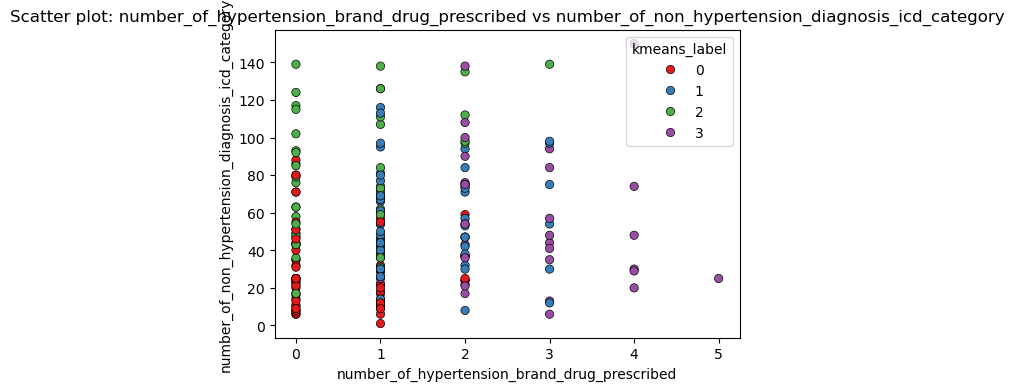

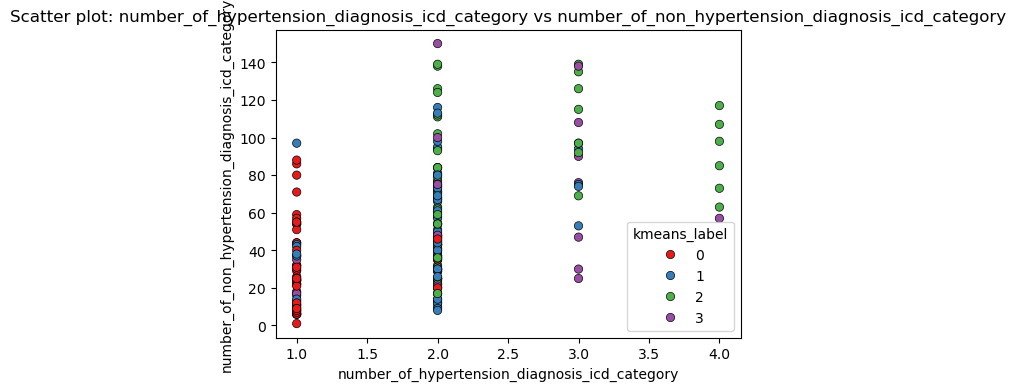

In [990]:
# 2d plot to check

variables = ['patient_age_as_of_2019', 'days_of_hypertension_diagnosis', 'days_of_hypertension_treatment',
             'number_of_hypertension_brand_drug_prescribed', 'number_of_hypertension_diagnosis_icd_category',
             'number_of_non_hypertension_diagnosis_icd_category']

# iterate through each pair of variables and plot
for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        plt.figure(figsize = (6, 4))
        sns.scatterplot(x = df_patient_summary[variables[i]], 
                        y = df_patient_summary[variables[j]], 
                        hue = df_patient_summary['kmeans_label'], palette = 'Set1', edgecolor = 'k')
        plt.title(f'Scatter plot: {variables[i]} vs {variables[j]}')
        plt.xlabel(variables[i])
        plt.ylabel(variables[j])
        plt.show()

In [991]:
# 3d plot to check
trace1 = go.Scatter3d(
    x= df_patient_summary['patient_age_as_of_2019'],
    y= df_patient_summary['days_of_hypertension_diagnosis'],
    z= df_patient_summary['days_of_hypertension_treatment_t'],
    mode='markers',
     marker=dict(
        color = df_patient_summary['kmeans_label'], 
        size= 10,
        line=dict(
            color= df_patient_summary['kmeans_label'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
    title= 'Clusters patient_age, diagnosis and treatment length',
    scene = dict(
            xaxis = dict(title  = 'patient age'),
            yaxis = dict(title  = 'diagnosis length'),
            zaxis = dict(title  = 'treatment length')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)



In [992]:
# Describe each cluster
cluster_descriptions = df_patient_summary[['kmeans_label',
                        'patient_age_as_of_2019',
                        'days_of_hypertension_diagnosis',
                        'days_of_hypertension_treatment',
                        'number_of_hypertension_brand_drug_prescribed',
                        'number_of_hypertension_diagnosis_icd_category',
                        'number_of_non_hypertension_diagnosis_icd_category']].groupby ('kmeans_label').describe()
print(cluster_descriptions)


             patient_age_as_of_2019                                           \
                              count       mean        std   min    25%   50%   
kmeans_label                                                                   
0                              52.0  65.692308  14.877985  23.0  57.75  65.0   
1                              61.0  74.704918   8.987666  55.0  68.00  77.0   
2                              54.0  73.796296  11.095434  42.0  68.00  78.5   
3                              33.0  57.272727  11.306173  35.0  52.00  56.0   

                          days_of_hypertension_diagnosis               ...  \
                75%   max                          count         mean  ...   
kmeans_label                                                           ...   
0             79.25  83.0                           52.0   335.596154  ...   
1             83.00  83.0                           61.0  1391.639344  ...   
2             83.00  83.0                        

In [993]:


## Output Analytical Tables for BI



In [994]:
output_data_path = "C:/Users/fzeng/OneDrive/Documents/Python Scripts/df_diagnosis_master.xlsx"
df_diagnosis_master.to_excel(output_data_path)
print('exported!')

exported!


In [995]:
output_data_path = "C:/Users/fzeng/OneDrive/Documents/Python Scripts/df_prescription_master.xlsx"
df_prescription_master.to_excel(output_data_path)
print('exported!')

exported!


In [996]:
output_data_path = "C:/Users/fzeng/OneDrive/Documents/Python Scripts/df_patient_summary.xlsx"
df_patient_summary.to_excel(output_data_path)
print('exported!')

exported!


In [997]:
output_data_path = "C:/Users/fzeng/OneDrive/Documents/Python Scripts/cluster_descriptions.xlsx"
cluster_descriptions.to_excel(output_data_path)
print('exported!')

exported!


In [998]:


#Physician Network Analysis 



In [1005]:
# physician network analysis data prep

# assuming diagnosis physician and prescribing physician have a referral relationship
# due to lack to physician id in prescription data and majoirty of physician ids in presrciption data are unique, we can only analyze physicians at a 
# higher level, e.g. specialty. we need to build an artificial connector between diagnosis and prescription. 
# for the simplicity, we build a connection based on time to analyze the relationship 
# between diagnosis physician and prescribing physician specialty:
# physicians shared patients during an episode of care (same month), we counted them as connected to each

# ensure date type
df_diagnosis_master['diagnosis_date'] = pd.to_datetime(df_diagnosis_master['diagnosis_date'])
df_prescription_master['prescription_filled_date'] = pd.to_datetime(df_prescription_master['prescription_filled_date'])

# function to get the end of the month as the connector
def get_end_of_month(date):
    date = pd.to_datetime(date)  # Ensure the input is a datetime object
    return date + pd.offsets.MonthEnd(0)


# build the eom connector
df_diagnosis_master['eom_date'] = df_diagnosis_master['diagnosis_date'].apply(get_end_of_month)
df_prescription_master['eom_date'] = df_prescription_master['prescription_filled_date'].apply(get_end_of_month)

# prep diagnosis data
df_diagnosis_master = df_diagnosis_master[df_diagnosis_master['hypertension_diagnosis_ind'] == 'Hypertension']
df_diagnosis_master.dropna(subset=['physician_specialty'], inplace=True)
df_diagnosis_master = df_diagnosis_master.drop(df_diagnosis_master[df_diagnosis_master['physician_specialty'] == 'UNKNOWN'].index)

# prep prescription data
df_prescription_master.dropna(subset=['physician_specialty'], inplace=True)
df_prescription_master = df_prescription_master.drop(df_prescription_master[df_prescription_master['physician_specialty'] == 'UNKNOWN'].index)

# group diagnosis
df_diagnosis_agg = df_diagnosis_master.groupby(
    ['patient_id_number', 'eom_date', 'physician_specialty']
).agg(
    diagnosis_claim_count=('claim_id_number', 'nunique')  # Unique diagnosis claims count
).reset_index()

# group prescription 
df_prescription_agg = df_prescription_master.groupby(
    ['patient_id_number', 'eom_date','physician_specialty']
).agg(
    prescription_claim_count=('claim_id_number', 'nunique'),  # Unique prescription claims count
    patient_paid_amount=('patient_paid_amount', 'sum')  # Total prescription cost
).reset_index()

# merge diagnosis and prescription based on patient and eom connector
df_physician_master = pd.merge(
    df_diagnosis_agg, 
    df_prescription_agg, 
    how='outer',  # Change to outer join
    left_on=['patient_id_number', 'eom_date'], # From diagnosis aggregation
    right_on=['patient_id_number', 'eom_date'], # From prescription aggregation
    suffixes=('_diagnosis', '_prescription')
)

# aggregate merged data for network analysis
df_physician_summary = df_physician_master.groupby(
    ['physician_specialty_diagnosis','physician_specialty_prescription']
).agg(
    patient_count=('patient_id_number', 'nunique'),  # Unique prescription claims count
    patient_paid_amount=('patient_paid_amount', 'sum')  # Total prescription cost
).reset_index()

df_physician_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   physician_specialty_diagnosis     119 non-null    object 
 1   physician_specialty_prescription  119 non-null    object 
 2   patient_count                     119 non-null    int64  
 3   patient_paid_amount               119 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ KB


In [1007]:
df_physician_master.head()


,patient_id_number,eom_date,physician_specialty_diagnosis,diagnosis_claim_count,physician_specialty_prescription,prescription_claim_count,patient_paid_amount
0,167687962,2014-01-31,NaN,NaN,FAMILY MEDICINE,1.0,10.0
1,167687962,2014-03-31,FAMILY MEDICINE,2.0,NaN,NaN,NaN
2,167687962,2014-04-30,NaN,NaN,FAMILY MEDICINE,1.0,10.0
3,167687962,2014-07-31,NaN,NaN,FAMILY MEDICINE,1.0,10.0
4,167687962,2014-09-30,FAMILY MEDICINE,2.0,NaN,NaN,NaN


In [1009]:
df_physician_summary.head()

,physician_specialty_diagnosis,physician_specialty_prescription,patient_count,patient_paid_amount
0,ABDOMINAL SURGERY,"FAMILY PRACTICE, GERIATRIC MEDICINE",1,12.80
1,ANATOMIC PATHOLOGY,INTERNAL MEDICINE,1,0.00
2,ANESTHESIOLOGY,FAMILY MEDICINE,2,89.75
3,ANESTHESIOLOGY,FAMILY PRACTICE,1,41.59
4,ANESTHESIOLOGY,HEMATOLOGY/ONCOLOGY,1,4.60


In [1000]:
output_data_path = "C:/Users/fzeng/OneDrive/Documents/Python Scripts/df_physician_master.xlsx"
df_physician_master.to_excel(output_data_path)
print('exported!')

exported!


In [1001]:
output_data_path = "C:/Users/fzeng/OneDrive/Documents/Python Scripts/df_physician_summary.xlsx"
df_physician_summary.to_excel(output_data_path)
print('exported!')

exported!


In [1057]:
# physician network analysis

# assuming diagnosis physicians refer patients to prescribing physicians, use a directed network

# initialize an empty directed graph
G = nx.DiGraph()

# iterate through each row and add edges between diagnosing and prescribing specialties
for index, row in df_physician_summary.iterrows():
    # Add an edge from diagnosis specialty to prescribing specialty
    G.add_edge(row['physician_specialty_diagnosis'], 
               row['physician_specialty_prescription'], 
               patient_count=row['patient_count'], 
               patient_paid_amount=row['patient_paid_amount'])

# Degree Centrality (In-Degree and Out-Degree)
in_degree_centrality = nx.in_degree_centrality(G)  # Receives patients from other specialties
out_degree_centrality = nx.out_degree_centrality(G)  # Refers patients to other specialties

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Eigenvector Centrality (influencers within the network)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

# Display and Sort Centrality Measures
df_physician_specialty_centrality = pd.DataFrame({
    'specialty': in_degree_centrality.keys(),
    'in_degree_centrality': in_degree_centrality.values(),
    'out_degree_centrality': out_degree_centrality.values(),
    'betweenness_centrality': betweenness_centrality.values(),
    'closeness_centrality': closeness_centrality.values(),
    'eigenvector_centrality': eigenvector_centrality.values()
})

# Sort by key influencers based on in-degree and betweenness centrality
df_key_influencers = df_physician_specialty_centrality.sort_values(by='in_degree_centrality', ascending=False)
# top 5 influencers
df_key_influencers.head(5)


,specialty,in_degree_centrality,out_degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality
5,FAMILY MEDICINE,0.488889,0.177778,0.088131,0.592593,0.462922
3,INTERNAL MEDICINE,0.444444,0.288889,0.154007,0.573477,0.414919
6,FAMILY PRACTICE,0.333333,0.155556,0.042054,0.500782,0.358014
9,CARDIOVASCULAR DISEASES,0.266667,0.200000,0.082963,0.487062,0.411020
13,NEPHROLOGY,0.133333,0.111111,0.011869,0.428380,0.264519


C:\Users\fzeng\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning:

invalid value encountered in sqrt



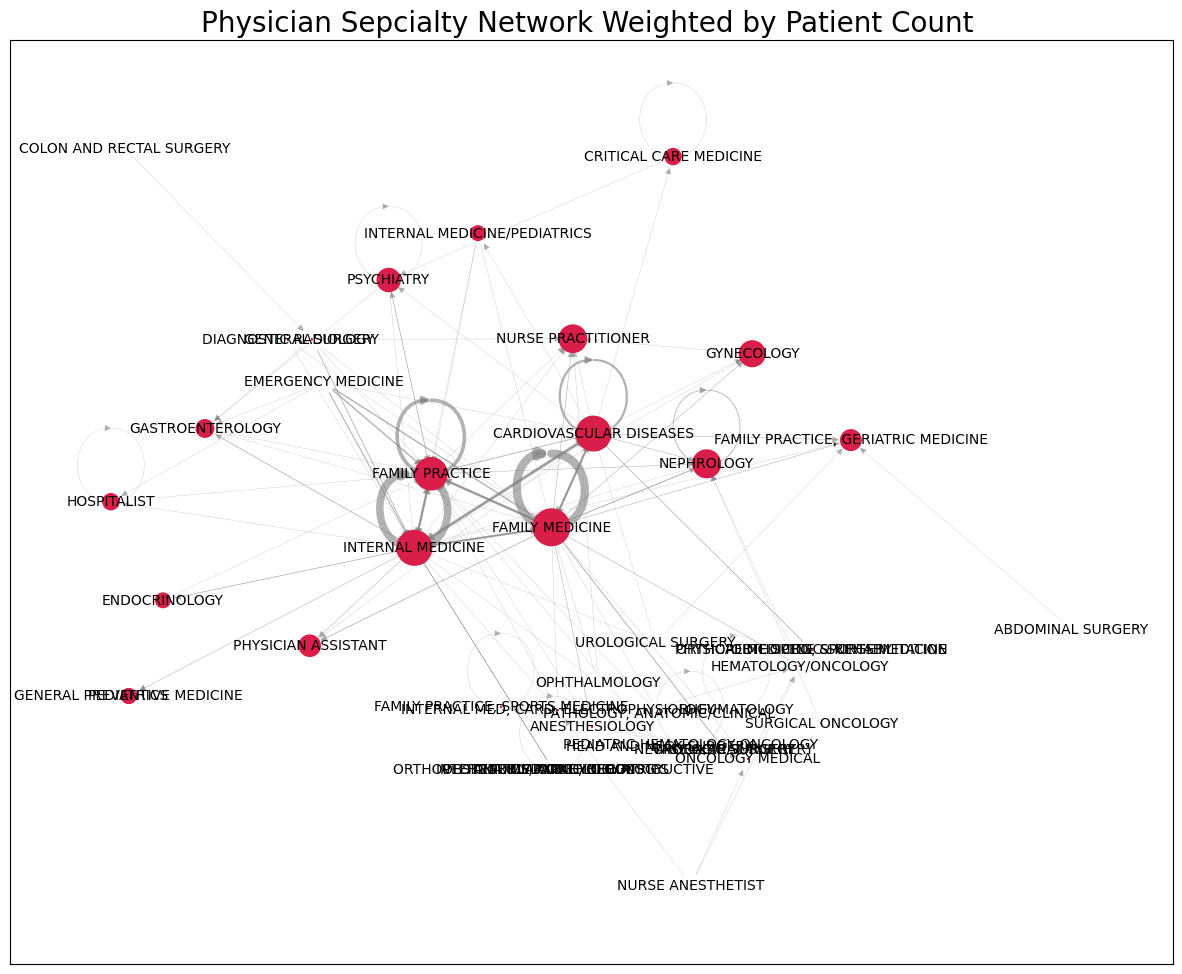

In [1049]:
# Visualize the Network by patient_count
plt.figure(figsize=(15, 12))

# Define node size by centrality metrics (e.g., eigenvector centrality)
node_size = [eigenvector_centrality[n] * 1500 for n in G.nodes]

# Define edge weights by patient count or prescription cost
edge_width = [G[u][v]['patient_count'] * 0.2 for u, v in G.edges]

# Draw the network graph
#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)  # Force-directed layout
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='#D91E49', alpha=1)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Add title and display the plot
plt.title("Physician Sepcialty Network Weighted by Patient Count ", size=20)
plt.show()


C:\Users\fzeng\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning:

invalid value encountered in sqrt



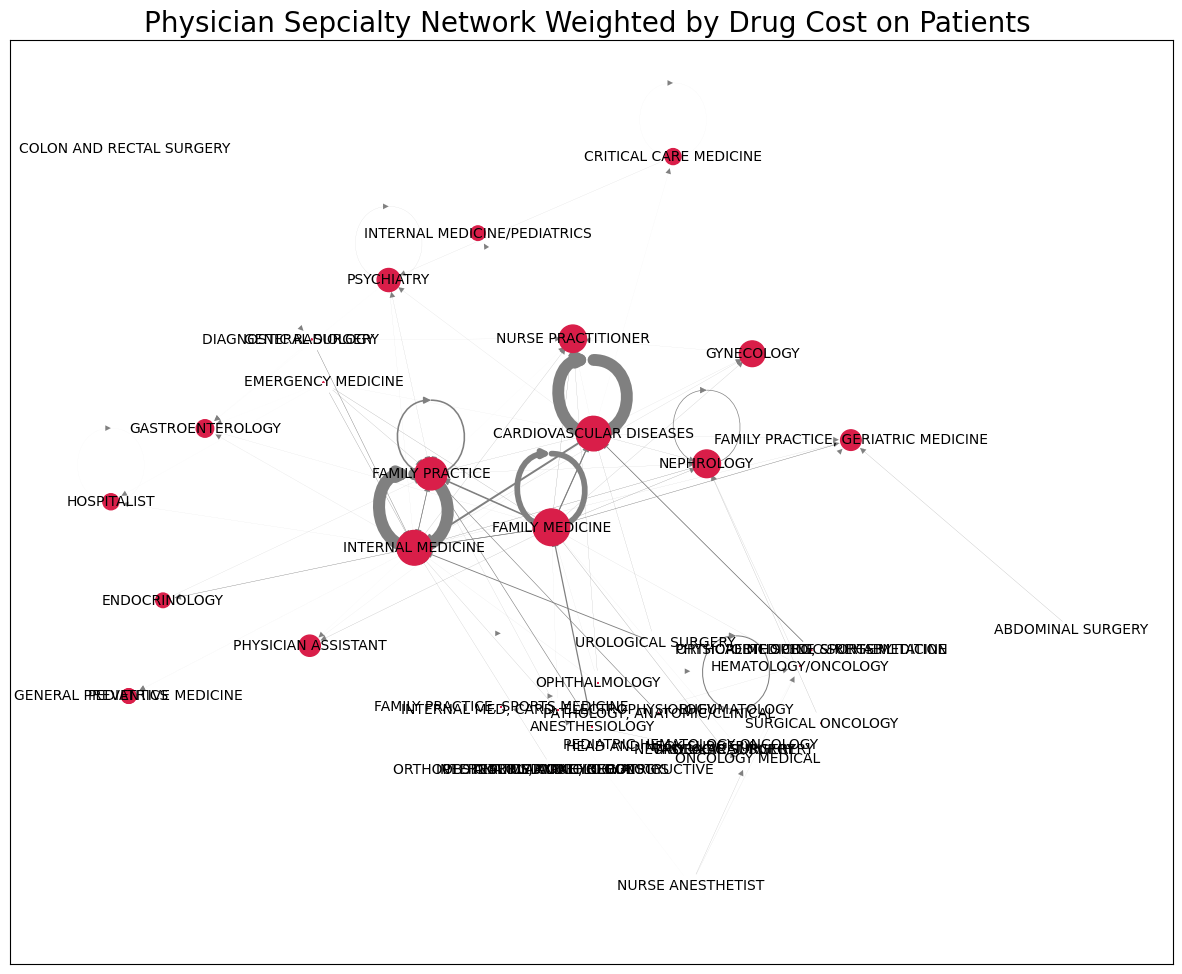

In [1085]:
# Visualize the Network by patient_paid_amount
plt.figure(figsize=(15, 12))

# Define node size by centrality metrics (e.g., eigenvector centrality)
node_size = [eigenvector_centrality[n] * 1500 for n in G.nodes]

# Define edge weights by patient count or prescription cost
edge_width = [G[u][v]['patient_paid_amount'] * 0.01 for u, v in G.edges]

# Draw the network graph
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G,k=10/np.sqrt(G.order()))  # Force-directed layout
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='#D91E49', alpha=1)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=1)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Add title and display the plot
plt.title("Physician Sepcialty Network Weighted by Drug Cost on Patients ", size=20)
plt.show()


In [1015]:
# Export the Centrality Metrics for further analysis
output_data_path = "C:/Users/fzeng/OneDrive/Documents/Python Scripts/df_physician_specialty_centrality.xlsx"
df_physician_specialty_centrality.to_excel(output_data_path)

print('exported!')

exported!


In [1017]:
output_data_path = "C:/Users/fzeng/OneDrive/Documents/Python Scripts/df_key_influencers.xlsx"
df_key_influencers.to_excel(output_data_path)

print('exported!')

exported!
